<a href="https://colab.research.google.com/github/Kridr/Predict-Next-Strategy/blob/main/predict_next_strategy_crypto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing necessary libraries:
1. pycoingecko (to obtain market info)
2. river (online ml library)

In [1]:
!pip install pycoingecko
!pip install river

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 24.9 MB/s 


Import libraries

In [2]:
import pandas as pd
import numpy as np

from pycoingecko import CoinGeckoAPI
import time
from scipy.stats import percentileofscore
from scipy.optimize import curve_fit
import os.path
import joblib

import calendar
import datetime as dt
import math
from river import compose
from river import linear_model
from river import optim
from river import preprocessing
from river import datasets
from river import time_series
from river import metrics

import matplotlib.pyplot as plt

Introducing portfolio size

In [3]:
PORTFOLIO_SIZE = 1_000_000

Initializing Coin Gecko API to gain market information

In [4]:
cg = CoinGeckoAPI()

Obtaining all available coins.

Initially there was a filter (see commented line), but then it was removed.

In [8]:
coins_markets = cg.get_coins_markets(vs_currency='usd')

#coins_markets = list(filter(lambda x: x['current_price'] >= 10, coins_markets))
ids_to_prices = {x['id']: x['current_price'] for x in coins_markets}

list(ids_to_prices.keys())[:15]

['bitcoin',
 'ethereum',
 'tether',
 'usd-coin',
 'binancecoin',
 'binance-usd',
 'ripple',
 'cardano',
 'solana',
 'polkadot',
 'dogecoin',
 'shiba-inu',
 'staked-ether',
 'matic-network',
 'dai']

Defining functions for get datasets from information that we get from API.

We transform information to format that can be used in River library

In [9]:
def create_dataset(data):

    dataset = []

    for i in range(len(data)):
        X = {
            'date': dt.datetime.fromtimestamp(data[i][0] / 1e3)
        }
        dataset.append((X, data[i][1]))

    return dataset

def train_test_split(data, train_size=0.75):
    ind = int(len(data) * train_size)

    train_data = create_dataset(data[:ind])
    test_data = create_dataset(data[ind:])

    return train_data, test_data

We need to get serialised a dictionary of models. It is contained in .pkl file.

The dictionary of models maps coin id to its corresponding model

In [10]:
dirname = os.path.dirname('__file__')
dict_fname = os.path.join(dirname, f'models.pkl')

if os.path.isfile(dict_fname):
    ids_to_models = joblib.load(dict_fname)
else:
    ids_to_models = {}

In the next cell we iterate through all coins we have and either create model for the coin or tune the model we already have.

If we tune the model that exists then we get prices from the last data the model was trained to current date. It was not tested.

For model we choose SNARIMAX + Linear Regression. It is just a baseline to demonstrate the idea. Honestly, documentation and functionality of the library is relatively poor and I could find lots of examples for my case, so lots of research needed.

Also it is needed to mention that despite we have a unified model for different coins, we have to change one parameter - learning rate. So how to find an appropriate lr?

First approach I tried is just manually build function `y = f(x)`, where `x` is a mean of price and `y` is lr. I manually found several values `y`and `x` and tried to find a function based on it. I used `curve_fit` from `scipy` and found an arguments for function `y = a * np.sqrt(b * x) + c`. The result was not that good. I think it is a good idea but lots of research needed.

Second approach was to iteratively find an appropriate lr. The method I used is simiral to finding root of the function, but it finds maximum of function (serious obstacle is that we dont know the function). So the idea is to iniatilly set the possible range of lr ([0, 1]) and then divide it into to parts and then compare value of R2 metric based on the middle value of each part. We choose the part where calculated value of R2 metric is bigger. We need to repeat above steps until we find a lr that gives us R2 metric value bigger than 0.95 or until steps are over (max steps is 10). This approach suprisingly works for most coins. And one of my friends suggested to divide range into 3 or more parts to improve effectiveness of my approach. We do not include coins wher R2 metric is less than 0.9. The method has a disadvantage. It need to retrain several times using different learning rates (lr) which takes a lot of time. But we have some API limitations, so it does not really matter.

In [14]:
for id in ids_to_prices.keys():
    print(f'Obtaining history prices for {id}')

    if id in ids_to_models:
        model, date = ids_to_models[id]

        days = (np.datetime64('today') - date) / np.timedelta64(1,'D')

        print(f'Pretrained model for {id} has been found! Doing some online ML magic...')
        data = cg.get_coin_market_chart_by_id(id=id, 
                                              vs_currency='usd', 
                                              days=days, 
                                              interval='daily'
                                              )
        dataset = create_dataset(data['prices'])

        for X, y in dataset:
            model.learn_one(X, y)

    else:
        print(f'Oops... Pretrained model for {id} has not been found :( Training model from scratch...')
        data = cg.get_coin_market_chart_by_id(id=id, 
                                              vs_currency='usd', 
                                              days=365*5, 
                                              interval='daily'
                                              )
        train_data, test_data = train_test_split(data['prices'])


        def get_month_distances(x):
            return {
                calendar.month_name[month]: math.exp(-(x['date'].month - month) ** 2)
                for month in range(1, 13)
            }

        def get_ordinal_date(x):
            return {'ordinal_date': x['date'].toordinal()}

        extract_features = compose.TransformerUnion(
            get_ordinal_date,
            #get_month_distances
        )


        def get_lr(x, a, b, c):
            return float(a * np.sqrt(x * b) + c)

        abc = [0.00472611, 1.17425412, -0.02040101]
        lr = get_lr(np.mean([e[1] for e in train_data]), *abc)

        def find_metric(lr):
            model = (
                extract_features |
                time_series.SNARIMAX(
                    p=13,
                    d=1,
                    q=150,
                    m=12,
                    sp=150,
                    sd=0,
                    sq=2,
                    regressor=(
                        preprocessing.StandardScaler() |
                        linear_model.LinearRegression(
                            optimizer=optim.Adam(lr=lr)
                        )
                    )
                )
            )

            for x, y in train_data:
                model = model.learn_one(x, y)

            metric = metrics.R2()

            for x, yt in test_data:
                yp = model.forecast(horizon=1)[0]
                metric.update(yt, yp)
                model = model.learn_one(x, yt)

            return metric.get(), model

        l_lr = 0
        r_lr = 1
        l_val = find_metric(l_lr)
        r_val = find_metric(r_lr)

        cur_lr = (l_lr + r_lr) / 2
        cur_val, model = find_metric(cur_lr)

        steps = 0
        while cur_val < 0.95:
            lc_lr = (l_lr + cur_lr) / 2
            rc_lr = (r_lr + cur_lr) / 2

            lc_val, lc_model = find_metric(lc_lr)
            rc_val, rc_model = find_metric(rc_lr)

            if lc_val >= rc_val:
                r_lr = cur_lr
                r_val = cur_val

                cur_lr = lc_lr
                cur_val = lc_val
                model = lc_model
            else:
                l_lr = cur_lr
                l_val = cur_val

                cur_lr = rc_lr
                cur_val = rc_val
                model = rc_model
            if steps >= 10:
                break
            else:
                steps += 1

        if cur_val < 0.9:
            print('Metric values is too low... We will not include this coin')
            continue
        else:
            print(cur_lr)
            print(cur_val)

        print()
    
    ids_to_models[id] = (model, np.datetime64('today'))

    time.sleep(1.5)

Obtaining history prices for bitcoin
Oops... Pretrained model for bitcoin has not been found :( Training model from scratch...
0.75
0.963371034499317

Obtaining history prices for ethereum
Oops... Pretrained model for ethereum has not been found :( Training model from scratch...
0.25
0.9606491417274013

Obtaining history prices for tether
Oops... Pretrained model for tether has not been found :( Training model from scratch...
Metric values is too low... We will not include this coin
Obtaining history prices for usd-coin
Oops... Pretrained model for usd-coin has not been found :( Training model from scratch...
Metric values is too low... We will not include this coin
Obtaining history prices for binancecoin
Oops... Pretrained model for binancecoin has not been found :( Training model from scratch...
0.046875
0.9522717877081264

Obtaining history prices for binance-usd
Oops... Pretrained model for binance-usd has not been found :( Training model from scratch...
Metric values is too low..

The code below don't work for now, but in future version in it will be corrected

In [28]:
joblib.dump(ids_to_models, dict_fname)

PicklingError: ignored

In the code below I tried to find `y=f(x)` where `x` is average price and `y` is learning rate 

[ 0.00472611  1.17425412 -0.02040101]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


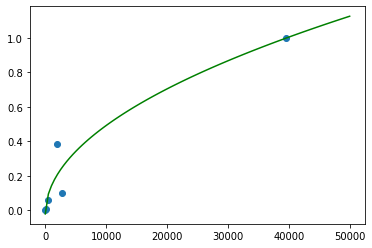

In [16]:
def func(x, a, b, c):
    return a * np.sqrt(b * x) + c#d * x + c

x = np.array([39540, 2773, 390, 66, 1889, 22])
y_adam = np.array([1, 0.1, 0.06, 0.007, 0.386, 0.002])

y = y_adam

plt.scatter(x, y)

popt, pcov = curve_fit(func, x, y)
print(popt)

nx = np.linspace(0, 50000, 100)
fx = func(nx, *popt)

plt.plot(nx, fx, color='g')

In this code we calculate rate for based on tommorow price and today price

In [26]:
ids_to_prices_and_ratio = {}
for id, (model, _) in ids_to_models.items():
    td = dt.datetime.utcnow()
    tomorrow_date = dt.date(td.year, td.month, td.day + 1)
    X_tommorow = {
        'date': tomorrow_date
    }
    next_day_price = model.forecast(horizon=1)[0]
    ids_to_prices_and_ratio[id] = [ids_to_prices[id], next_day_price / ids_to_prices[id]]

df = pd.DataFrame.from_dict(ids_to_prices_and_ratio, orient='index',
                            columns =['current_price', 'ratio'])
df

,current_price,ratio
bitcoin,21591.000000,0.934179
ethereum,1756.020000,0.939895
binancecoin,293.530000,0.869421
cardano,0.507859,0.880212
solana,35.020000,0.791840
staked-ether,1707.180000,0.903554
matic-network,0.887924,0.910113
avalanche-2,20.360000,0.953826
wrapped-bitcoin,21562.000000,1.011087
ethereum-classic,38.420000,0.928858


Finally we need to get coins where ratio is more than 1, sort them and calculate norm_ratio (total share) of each coin

In [27]:
df = df.sort_values('ratio', ascending=False)
df = df[df['ratio'] > 1]

df['norm_ratio'] = df['ratio'] / df['ratio'].sum()
df['coins_to_buy'] = df['norm_ratio'] * PORTFOLIO_SIZE / df['current_price']
df

,current_price,ratio,norm_ratio,coins_to_buy
neo,9.750000,1.302315,0.129970,13330.291299
fantom,0.269371,1.240842,0.123835,459720.553750
dash,47.990000,1.155820,0.115350,2403.631101
bitcoin-cash,130.010000,1.120313,0.111807,859.984987
celsius-degree-token,1.560000,1.095200,0.109300,70064.351794
litecoin,62.560000,1.054064,0.105195,1681.506796
enjincoin,0.541090,1.034274,0.103220,190763.103019
wrapped-bitcoin,21562.000000,1.011087,0.100906,4.679803
kucoin-shares,9.650000,1.006178,0.100416,10405.803053


What can be improven:

1. Repair pickling
2. Test tuning process
3. Replace Linear Regression with something more effective.
4. Change the way to choose optimal learning rate. Try to divide range into 3 or more parts. 